## Machine Learning applied to identify Active Antimicobrial Peptides

In this notebook is described all the procedure used to train and test the Activity model.

In [1]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import pickle
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import precision_recall_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

%matplotlib inline

In [17]:
# This function wil convert the undefined MIC values or MIC > 8 to 0.
def convert_mic(mic_value):
    if type(mic_value) == str and mic_value.startswith('>'):
        return 0
    elif float(mic_value) > 8:
        return 0
    else:
        return 1
    
convert_mic('>64')

0

In [18]:
# Load meta data
meta_data = pd.read_excel('data/Cumulative_Peptide_data_PG1.xlsx', index_col=0)
meta_data['MBC'] = [convert_mic(x) for x in meta_data['MBC']]
meta_data

,ID,Sequence,MBC,%Hemolysis
0,PG-1.37,HVRRLCYCRRRFCACVGS,1,2.600000
1,PG-1.20d,RGGRLRYCRRRFCVSVGR,1,1.607281
2,PG-1.62,RGGRLCYCRRRFCTCVGR,1,3.233927
3,PG-1.12A,RGGRLCYCRRRACVCVGR,1,12.103021
4,PG-1.16A,RGGRLCYCRRRFCVCAGR,1,15.821069
...,...,...,...,...
91,PG-1.32,HGWRLCYCRRRFCVCVGC,0,35.460367
92,PG-1.60,RGGRLCYCRRRFCVCVGF,0,36.664085
93,PG-1.25,RGWRLCYCRRRFCVCVGH,0,46.397292
94,PG-1.7,RRWCLCFCRRRFCVCVCR,0,51.181276


/stor/home/lcv454/miniconda3/envs/ML/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


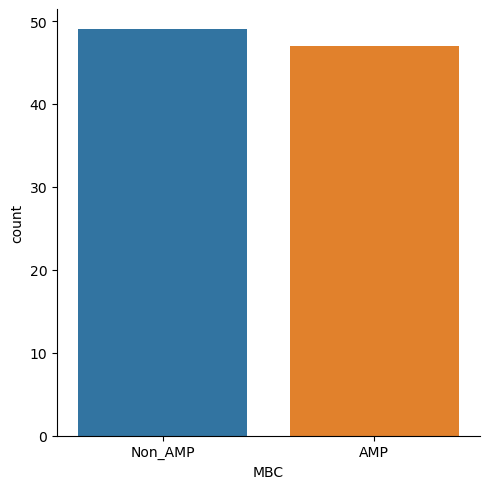

In [23]:
# Create the new target selectivity
sns.catplot(data=meta_data, x='MBC', kind='count')
plt.xticks([0,1], ['Non_AMP', 'AMP'])
plt.show()

## Define the Model

In [7]:
# # creates a empty dictionary, and updates it with the embedds
dir_path = 'data/embedding/esm2_15B_PG1/'

embeddings = {}
for file in os.listdir(dir_path):
    file_path = str(dir_path) + file 
    label = file.split('.pt')[0]
    embeddings[label] = np.array(torch.load(file_path)['mean_representations'][48])

# here I creating a dictionary with ID as key and semantic value as value 
data = meta_data.merge(pd.DataFrame.from_dict(embeddings, orient='index'), how='inner', left_on='ID', right_index=True)
data

,ID,Sequence,MBC,%Hemolysis,0,1,2,3,4,5,...,5110,5111,5112,5113,5114,5115,5116,5117,5118,5119
0,PG-1.37,HVRRLCYCRRRFCACVGS,1,2.600000,0.056671,-0.074099,-0.040746,0.217794,-0.197767,0.223628,...,-0.130863,-0.107892,0.140624,-0.169443,0.165775,-0.120193,0.094954,-0.000617,-0.199790,0.001056
1,PG-1.20d,RGGRLRYCRRRFCVSVGR,1,1.607281,0.133009,-0.124348,-0.109747,0.222604,-0.261453,0.138052,...,-0.105108,-0.053451,0.092585,-0.201894,0.094672,-0.104331,0.135752,0.036512,-0.230271,0.020399
2,PG-1.62,RGGRLCYCRRRFCTCVGR,1,3.233927,0.155696,-0.016959,-0.179328,0.153639,-0.241203,0.130882,...,-0.160722,-0.136943,0.049061,-0.175572,0.109034,-0.239965,-0.050614,-0.096664,-0.249927,0.020688
3,PG-1.12A,RGGRLCYCRRRACVCVGR,1,12.103021,0.056310,-0.137829,-0.098538,0.162526,-0.252675,0.163847,...,-0.124351,-0.181434,0.037783,-0.201551,0.092573,-0.168867,0.078524,-0.003103,-0.212419,0.049512
4,PG-1.16A,RGGRLCYCRRRFCVCAGR,1,15.821069,0.122564,-0.024471,-0.127546,0.165324,-0.258667,0.142153,...,-0.155189,-0.155856,0.061196,-0.220575,0.092058,-0.220014,0.025014,-0.053914,-0.198191,0.036471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,PG-1.32,HGWRLCYCRRRFCVCVGC,0,35.460367,0.007245,-0.115889,-0.040796,0.235570,-0.216340,0.226666,...,-0.166121,-0.146094,0.080064,-0.143502,0.155125,-0.067742,0.087349,-0.027154,-0.214921,0.023557
92,PG-1.60,RGGRLCYCRRRFCVCVGF,0,36.664085,0.143025,-0.030791,-0.110694,0.109217,-0.223111,0.105739,...,-0.119124,-0.189840,-0.030339,-0.218860,0.098898,-0.174355,0.023488,-0.059298,-0.252023,0.029996
93,PG-1.25,RGWRLCYCRRRFCVCVGH,0,46.397292,0.068697,-0.038422,-0.142241,0.184863,-0.232976,0.162749,...,-0.180917,-0.172996,0.046710,-0.179037,0.106190,-0.103997,-0.029128,0.000693,-0.243295,0.019351
94,PG-1.7,RRWCLCFCRRRFCVCVCR,0,51.181276,0.066839,-0.037917,-0.087912,0.137855,-0.218455,0.279858,...,-0.167717,-0.251613,-0.086687,-0.231941,0.015133,-0.017062,0.048716,-0.028251,-0.203544,-0.114390


In [19]:
 # define target to evaluete the model
target = data["MBC"]
target

0     1
1     1
2     1
3     1
4     1
     ..
91    0
92    0
93    0
94    0
95    0
Name: MBC, Length: 96, dtype: int64

In [20]:
# define target
features = data.iloc[:, meta_data.shape[1]:]
features.head()

,0,1,2,3,4,5,6,7,8,9,...,5110,5111,5112,5113,5114,5115,5116,5117,5118,5119
0,0.056671,-0.074099,-0.040746,0.217794,-0.197767,0.223628,-0.119524,0.080779,-0.021853,0.285255,...,-0.130863,-0.107892,0.140624,-0.169443,0.165775,-0.120193,0.094954,-0.000617,-0.199790,0.001056
1,0.133009,-0.124348,-0.109747,0.222604,-0.261453,0.138052,-0.132696,0.162016,-0.073308,0.382890,...,-0.105108,-0.053451,0.092585,-0.201894,0.094672,-0.104331,0.135752,0.036512,-0.230271,0.020399
2,0.155696,-0.016959,-0.179328,0.153639,-0.241203,0.130882,-0.101294,0.178330,-0.043959,0.144877,...,-0.160722,-0.136943,0.049061,-0.175572,0.109034,-0.239965,-0.050614,-0.096664,-0.249927,0.020688
3,0.056310,-0.137829,-0.098538,0.162526,-0.252675,0.163847,-0.120923,0.205509,-0.078092,0.267088,...,-0.124351,-0.181434,0.037783,-0.201551,0.092573,-0.168867,0.078524,-0.003103,-0.212419,0.049512
4,0.122564,-0.024471,-0.127546,0.165324,-0.258667,0.142153,-0.093198,0.185513,-0.060469,0.173319,...,-0.155189,-0.155856,0.061196,-0.220575,0.092058,-0.220014,0.025014,-0.053914,-0.198191,0.036471


In [48]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

print(f'Train set shape: {X_train.shape}, Test set shape: {X_test.shape}')

Train set shape: (76, 5120), Test set shape: (20, 5120)


In [25]:
# create a list of classifiers to test
classifiers = [
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    GaussianNB(),
    SVC(),
    RandomForestClassifier()
]

# create a dictionary of hyperparameters to search over for each classifier
param_grids = [
    {'n_neighbors': [5, 10, 30, 50], 'weights': ['uniform', 'distance'], 'p': [1, 2]},
    {'max_depth': [None, 2, 4, 6], 'min_samples_split': [2, 4, 6]},
    {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]},
    {'kernel': ['rbf'], 'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto', 1, 0.1, 0.01], 'max_iter': [-1], 'class_weight': [None, 'balanced']},
    {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 50], 'min_samples_split': [5, 10, 50], 'max_features': ['sqrt', 'log2']}
]

# create a list of names for the classifiers for printing results
model_names = ["KNN", "Decision Tree", 'GaussianNB', "SVM", 'RandomForest']

# create an empty dataframe to store results
results_df = pd.DataFrame()

# loop over the classifiers and hyperparameter grids
for name, clf, param_grid in zip(model_names, classifiers, param_grids):
    # create a GridSearchCV object with 5-fold cross-validation
    grid = GridSearchCV(clf, param_grid, cv=10)
    # fit the grid search object to the training data
    grid.fit(X_train.values, y_train.values)
    # make predictions on the test data using the best model found by the grid search
    y_pred = grid.best_estimator_.predict(X_test)
    best_score = str(grid.best_score_.round(2))
    # evaluate the performance of the best model on the test data using accuracy score
    accuracy = metrics.accuracy_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)
    f1_score = metrics.f1_score(y_test, y_pred)
    
    print(f'Accuracy: {accuracy.round(2)}, Recall: {recall.round(2)}, Precision: {precision.round(2)}')
    
    # Saving results
    res_dict = {}
    res_dict["embedding"] = 'esm2_15B'
    res_dict["embed_size"] = features.shape[1]
    res_dict["model"] = name
    res_dict["Accuracy"] = accuracy.round(2)
    res_dict["recall"] = recall.round(2)
    res_dict["precision"] = precision.round(2)
    res_dict["f1"] = f1_score.round(2)
    res_dict["train_mean_10cv"] = best_score
    res_dict['best_params'] = str(grid.best_params_)
 
    # updating data frame with results
    results_df = pd.concat([results_df, pd.DataFrame(res_dict, index=[0])]).reset_index(drop=True)
    

results_df.to_excel('results/results_classification_MIC.xlsx')

Accuracy: 0.65, Recall: 0.91, Precision: 0.62
Accuracy: 0.85, Recall: 0.73, Precision: 1.0
Accuracy: 0.85, Recall: 0.91, Precision: 0.83
Accuracy: 0.9, Recall: 0.91, Precision: 0.91
Accuracy: 0.8, Recall: 0.82, Precision: 0.82


## Results Visualization

In [27]:
results = pd.read_excel('results/results_classification_MIC.xlsx', index_col=0)
results

,embedding,embed_size,model,Accuracy,recall,precision,f1,train_mean_10cv,best_params
0,esm2_15B,5120,KNN,0.65,0.91,0.62,0.74,0.63,"{'n_neighbors': 5, 'p': 1, 'weights': 'distance'}"
1,esm2_15B,5120,Decision Tree,0.85,0.73,1.00,0.84,0.61,"{'max_depth': 6, 'min_samples_split': 2}"
2,esm2_15B,5120,GaussianNB,0.85,0.91,0.83,0.87,0.59,{'var_smoothing': 1e-09}
3,esm2_15B,5120,SVM,0.90,0.91,0.91,0.91,0.66,"{'C': 100, 'class_weight': 'balanced', 'gamma'..."
4,esm2_15B,5120,RandomForest,0.80,0.82,0.82,0.82,0.70,"{'max_depth': 10, 'max_features': 'log2', 'min..."


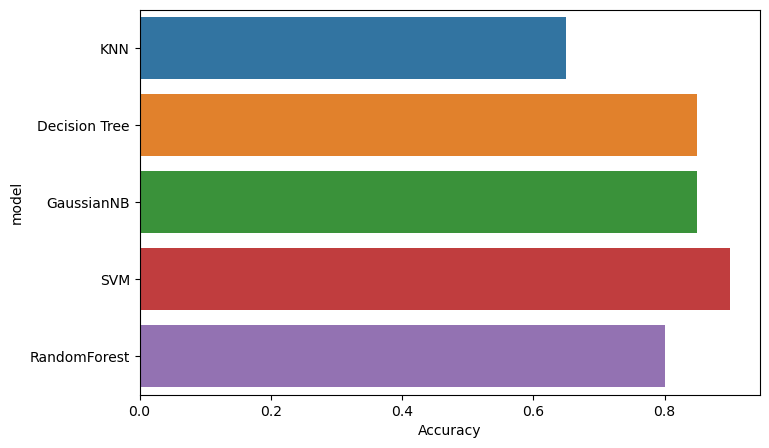

In [29]:
plt.figure(figsize=(8, 5))
sns.barplot(data=results, y='model', x='Accuracy')
plt.show()

## Fine Tunning Model with best hyperparameter found with Gridsearch


To determine if the model is overfitting, it's important to evaluate its performance on a validation set or using cross-validation. If the model's performance on the validation set is significantly worse than its performance on the training set, then it may be overfitting. In such cases, it may be necessary to adjust the hyperparameters of the model or to use a more complex kernel function.

The C parameter controls the trade-off between achieving a low training error and a low testing error. 

A linear kernel is a simple kernel function that can help to avoid overfitting by creating a linear decision boundary. 

## svc

In [31]:
results.iloc[3, 8]

"{'C': 100, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1}"

In [32]:
svc= SVC(kernel= 'rbf',
            C= 100,
            gamma='scale',
            max_iter=-1,
            class_weight= 'balanced',
            probability = True
            )

svc.fit(X_train, y_train)
svc.score(X_test, y_test)

0.9

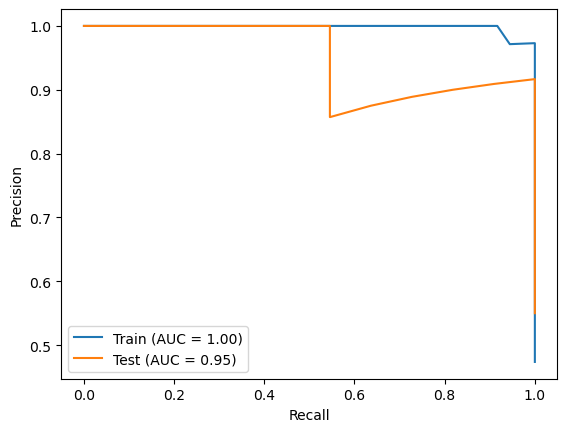

In [33]:
# Predict probabilities on the training and testing sets
y_train_proba = svc.predict_proba(X_train)[:, 1]
y_test_proba = svc.predict_proba(X_test)[:, 1]

# Compute precision-recall curves and AUCs for the training and testing sets
train_precision, train_recall, _ = precision_recall_curve(y_train, y_train_proba)
test_precision, test_recall, _ = precision_recall_curve(y_test, y_test_proba)
train_auc = auc(train_recall, train_precision)
test_auc = auc(test_recall, test_precision)

# Plot the precision-recall curves and AUCs for the training and testing sets
plt.plot(train_recall, train_precision, label=f'Train (AUC = {train_auc:.2f})')
plt.plot(test_recall, test_precision, label=f'Test (AUC = {test_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

## RF

In [34]:
RF= RandomForestClassifier(
    max_depth=50, 
    max_features='log2', 
    min_samples_split=5,
    n_estimators=50
)

RF.fit(X_train, y_train)
RF.score(X_test, y_test)

0.85

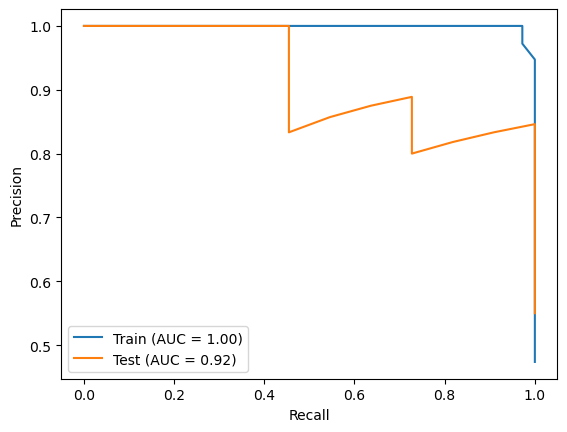

In [35]:
# Predict probabilities on the training and testing sets
y_train_proba = RF.predict_proba(X_train)[:, 1]
y_test_proba = RF.predict_proba(X_test)[:, 1]

# Compute precision-recall curves and AUCs for the training and testing sets
train_precision, train_recall, _ = precision_recall_curve(y_train, y_train_proba)
test_precision, test_recall, _ = precision_recall_curve(y_test, y_test_proba)
train_auc = auc(train_recall, train_precision)
test_auc = auc(test_recall, test_precision)

# Plot the precision-recall curves and AUCs for the training and testing sets
plt.plot(train_recall, train_precision, label=f'Train (AUC = {train_auc:.2f})')
plt.plot(test_recall, test_precision, label=f'Test (AUC = {test_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

## DecisionTreeClassifier

In [36]:
DT= DecisionTreeClassifier(
    max_depth=None, 
    min_samples_split=2
)

DT.fit(X_train, y_train)
DT.score(X_test, y_test)

0.85

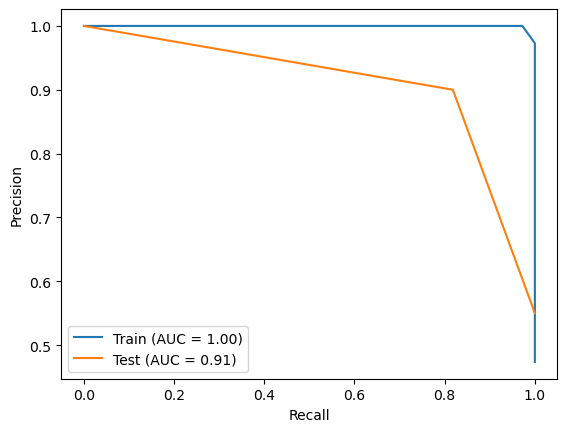

In [37]:
# Predict probabilities on the training and testing sets
y_train_proba = DT.predict_proba(X_train)[:, 1]
y_test_proba = DT.predict_proba(X_test)[:, 1]

# Compute precision-recall curves and AUCs for the training and testing sets
train_precision, train_recall, _ = precision_recall_curve(y_train, y_train_proba)
test_precision, test_recall, _ = precision_recall_curve(y_test, y_test_proba)
train_auc = auc(train_recall, train_precision)
test_auc = auc(test_recall, test_precision)

# Plot the precision-recall curves and AUCs for the training and testing sets
plt.plot(train_recall, train_precision, label=f'Train (AUC = {train_auc:.2f})')
plt.plot(test_recall, test_precision, label=f'Test (AUC = {test_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

## Gaussian NB

In [38]:
results_df.iloc[2, 8]

"{'var_smoothing': 1e-09}"

In [44]:
gnb = GaussianNB(
    var_smoothing= 1e-09,
    )

gnb.fit(X_train, y_train)
gnb.score(X_test, y_test)

0.85

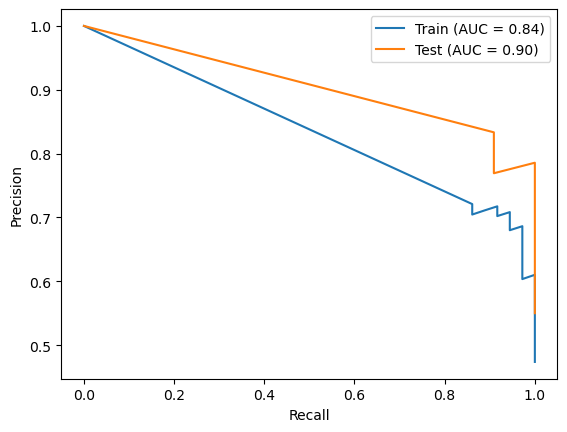

In [45]:
# Predict probabilities on the training and testing sets
y_train_proba = gnb.predict_proba(X_train)[:, 1]
y_test_proba = gnb.predict_proba(X_test)[:, 1]

# Compute precision-recall curves and AUCs for the training and testing sets
train_precision, train_recall, _ = precision_recall_curve(y_train, y_train_proba)
test_precision, test_recall, _ = precision_recall_curve(y_test, y_test_proba)
train_auc = auc(train_recall, train_precision)
test_auc = auc(test_recall, test_precision)

# Plot the precision-recall curves and AUCs for the training and testing sets
plt.plot(train_recall, train_precision, label=f'Train (AUC = {train_auc:.2f})')
plt.plot(test_recall, test_precision, label=f'Test (AUC = {test_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

## KNeighborsClassifier

In [42]:
knn = KNeighborsClassifier(
    n_neighbors=5,
    p= 1,
    weights='distance')

knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.65

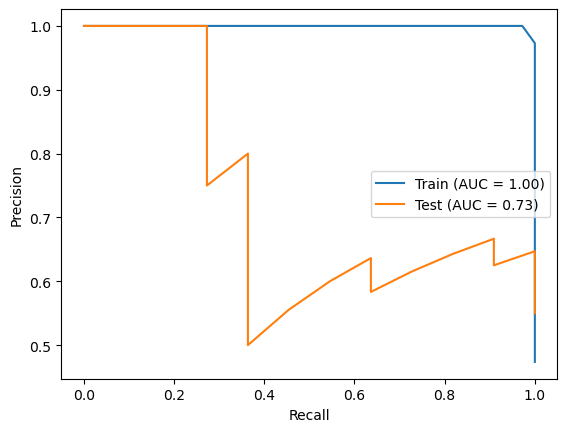

In [43]:
# Predict probabilities on the training and testing sets
y_train_proba = knn.predict_proba(X_train)[:, 1]
y_test_proba = knn.predict_proba(X_test)[:, 1]

# Compute precision-recall curves and AUCs for the training and testing sets
train_precision, train_recall, _ = precision_recall_curve(y_train, y_train_proba)
test_precision, test_recall, _ = precision_recall_curve(y_test, y_test_proba)
train_auc = auc(train_recall, train_precision)
test_auc = auc(test_recall, test_precision)

# Plot the precision-recall curves and AUCs for the training and testing sets
plt.plot(train_recall, train_precision, label=f'Train (AUC = {train_auc:.2f})')
plt.plot(test_recall, test_precision, label=f'Test (AUC = {test_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

# Save the model

GNB and lasso has less change to be overfitting

In [46]:
#pickle.dump(gnb, open('models/GNB_cls_esm2_15B_MIC.pkl', 'wb'))